In [1]:
import numpy as np
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
os.environ['TF_CPP_MIN_VLOG_LEVEL'] = '3'

import tensorflow as tf


from tensorflow import keras

from tensorflow.keras import layers

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Concatenate , Add, Dot, Activation, Lambda, BatchNormalization, LeakyReLU, Softmax, ReLU
from tensorflow.keras.models import Model

from tensorflow.image import flip_up_down, flip_left_right, rot90
from tensorflow.linalg import normalize

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import math

import matplotlib.pyplot as plt
import sys 
sys.path.append('..')
from layers.sorted_filters_with_shift import SortedConv2DWithShift

import datetime


c:\Users\Liam_gaming\anaconda3\envs\sys809\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from tensorflow.python.client import device_lib
#tf.disable_v2_behavior()
#tf.debugging.disable_traceback_filtering()

#print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print(tf.__version__ )

Num GPUs Available:  1
2.9.1


In [3]:
input_net = Input((32, 32, 3))

y, map = SortedConv2DWithShift(filters=10 , activation=ReLU(), padding='SAME')(input_net)

y = layers.Flatten()(y)
y = layers.Dense(200, activation=ReLU())(y)
y = layers.BatchNormalization(axis=-1)(y)
output_net  = layers.Dense(100, activation=Softmax())(y)

model = Model(inputs = input_net, outputs = output_net)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sorted_conv2d_with_shift (S  ((None, 32, 32, 10),     102       
 ortedConv2DWithShift)        (None, 32, 32))                    
                                                                 
 flatten (Flatten)           (None, 10240)             0         
                                                                 
 dense (Dense)               (None, 200)               2048200   
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 100)               20100 

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


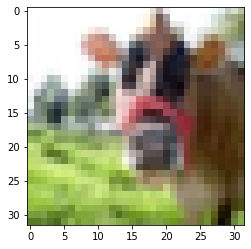

In [4]:
num_classes = 100
input_shape = (32, 32, 3)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()



# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

plt.imshow(x_train[0,:,:,:])



In [5]:
model = Model(inputs = input_net, outputs = y)

initial_learning_rate =  0.01

lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate,
    alpha = 1e-6,
    m_mul=0.999,
    first_decay_steps = 20)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)

log_dir = "logs_shift_experiments/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
)


checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

batch_size = 2
epochs = 1
#model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])

In [6]:
%tensorboard --logdir logs_shift_experiments/fit

UsageError: Line magic function `%tensorboard` not found.


(32, 32, 3)
avg (1, 8, 8, 1)
out 5.2518997
map tf.Tensor([9.], shape=(1,), dtype=float32)
done


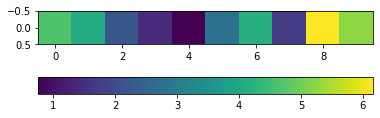

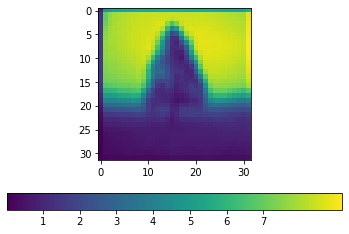

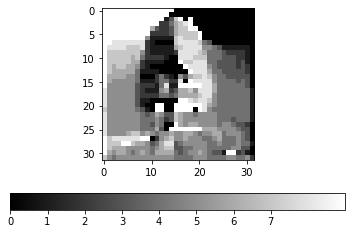

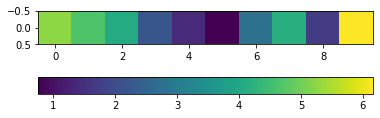

In [195]:
@tf.function
def roll(arg):
    x, map = arg
    print('here', map.shape)
    print('here', x.shape)


    return tf.gather(x, map)
@tf.function
def myRoll(arg):
    x, map = arg
    
    shifted = tf.zeros([0, 10]) #tf.TensorArray(tf.float32, size=40, dynamic_size=False)
    print('here', map.shape)
    print('input shape', x.shape)
    for i in range(64):
        k = map[i] % 10
        shifted = tf.concat([shifted, tf.concat([tf.slice(x, [i*16, 10-k], [16,k]), tf.slice(x, [i*16, 0], [16,10-k])], -1)], 0)

    print('out', shifted.shape)
    return shifted



patches=4


get_layer_output = K.function([model.input], model.layers[1].output)

n = 109

X = x_test[n]
print(X.shape)

out = np.array(get_layer_output(np.expand_dims(X, axis=0))[0])
#shifted = np.array(get_layer_output(np.expand_dims(X, axis=0))[1])
map = np.array(get_layer_output(np.expand_dims(X, axis=0))[1])


plt.figure(1)  
im = plt.imshow(out[:,0,1])   

plt.colorbar(im, ticks=range(8), orientation="horizontal")

plt.figure(2)  
im = plt.imshow(out[0, :, : , 0])  

plt.colorbar(im, ticks=range(8), orientation="horizontal")


plt.figure(3)  
im = plt.imshow(map[0], cmap='gray') 
plt.colorbar(im, ticks=range(8), orientation="horizontal")

patch_size = 4
map  = tf.cast(map, tf.float32)
map = tf.nn.avg_pool2d((tf.expand_dims(map, axis=-1)), ksize=[patch_size, patch_size] , strides=[patch_size, patch_size], padding='SAME')
print('avg', map.shape)

map = tf.repeat(map, repeats = patch_size, axis=1)
map = tf.repeat(map, repeats = 4, axis=2)

print('out', out[0,0,1,9])
print('map',map[0,0,1])

map  = tf.cast(map, tf.int64)

index = tf.squeeze(tf.sequence_mask(map,10), axis=-2)
index = tf.math.logical_not(index)
out_left = tf.ragged.boolean_mask(out, index)

index = tf.math.logical_not(index)
out_right = tf.ragged.boolean_mask(out, index)

out_shifted = tf.concat([out_left, out_right], axis=-1)

print('done')
#out1 = tf.reshape(out, [-1, 32, 32, 10 ])


plt.figure(4)  
'''im = plt.imshow(out1[:,0,0])  

plt.colorbar(im, ticks=range(8), orientation="horizontal")

plt.figure(5)  '''
im = plt.imshow([out_shifted[0, 0, 1]])  

plt.colorbar(im, ticks=range(8), orientation="horizontal")



In [198]:
print(index[0, 0, 1, ])
print(out[0, 0, 1, ])
print(out_left[0, 0, 1, ])
print(out_right[0, 0, 1, ])

print(map[0, 0, 1 ])
print(out_shifted[0, 0, 1, ])



tf.Tensor([ True  True  True  True  True  True  True  True  True False], shape=(10,), dtype=bool)
[4.684229   4.088064   2.1949782  1.414401   0.75688887 2.8039901
 4.155519   1.7276574  6.167313   5.2518997 ]
tf.Tensor([5.2518997], shape=(1,), dtype=float32)
tf.Tensor(
[4.684229   4.088064   2.1949782  1.414401   0.75688887 2.8039901
 4.155519   1.7276574  6.167313  ], shape=(9,), dtype=float32)
tf.Tensor([9], shape=(1,), dtype=int64)
tf.Tensor(
[5.2518997  4.684229   4.088064   2.1949782  1.414401   0.75688887
 2.8039901  4.155519   1.7276574  6.167313  ], shape=(10,), dtype=float32)


In [84]:
tf.RaggedTensor.from_tensor(out1, padding=0, ragged_rank=3, row_splits_dtype=tf.int32)

<tf.RaggedTensor [[[[0.0, 0.7518008, 0.0, 0.07587218, 0.30510306, 2.2470028, 3.6672583,
    2.52381, 5.557482, 5.59272]                                       ,
   [0.0, 4.088064, 2.1949782, 1.414401, 0.75688887, 2.8039901, 4.155519,
    1.7276574, 6.167313, 5.2518997]                                     ,
   [0.0, 4.4181137, 2.3985133, 1.5343769, 0.76932454, 2.8721192, 4.250799,
    1.7071693, 6.320815, 5.3395777]                                       ,
   ..., [], [], []],
  [[0.0, 2.1077445, 1.8260822, 2.5864766, 3.3052006, 6.4447064, 8.379952,
    6.242959, 10.074447, 8.111772]                                       ,
   [0.0, 7.434674, 6.298918, 6.0896688, 5.316704, 9.055386, 10.544804,
    6.841101, 11.702086, 7.553796]                                    ,
   [0.0, 8.077639, 6.7795377, 6.480469, 5.586491, 9.394007, 10.914227,
    6.928129, 12.056224, 7.6800666]                                   ,
   ..., [], [], []],
  [[0.0, 2.020402, 1.713198, 2.4499805, 3.1396997, 6.3285174, 8.2

In [ ]:
tf.RaggedTensor.from_nested_row_splits(out, padding=-, ragged_rank=3, row_splits_dtype=tf.int32)

In [ ]:
model.layers[5].scale_a

In [106]:
tf.cast(map > 0, tf.float32)

<tf.Tensor: shape=(1, 32, 32, 1), dtype=float32, numpy=
array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]]], dtype=float32)>